# ガチで理解する 実践編1
　ここでは、NISQ(Noisy Intermediate Scale Quantum)デバイスと呼ばれる、小規模で多少ノイズを含む量子コンピュータをうまく活用する方法として期待されている、ハイブリッド量子古典アルゴリズムについて紹介する。現在、GoogleやIBM、そしてベンチャー企業のRigetti Computingなどはすでに20量子ビット程度の量子コンピュータを実現し、近い将来50~100量子ビット規模の量子コンピュータが実現すると期待されている。この規模の量子コンピュータであれば、十分演算の精度が高ければ、特定のベンチマークにおいて従来コンピュータに対する優位性を示すことができるとされている。しかし、素因数分解などの高度な量子アルゴリズムを実装して、役に立つ問題に対して従来コンピュータに対する優位性を示すことはまだまだ厳しいと考えられている。こういった、過渡期としての量子コンピュータをうまく利用して、何かの役に立てようという取り組みが現在さかんに行われている。中でも、すべての計算を量子コンピュータ側でやるのではなく、従来コンピュータと組み合わせたハイブリッド型で、量子コンピュータを利用する、ハイブリッド量子古典アルゴリズムが注目されている。ここでは、パラメータ付き量子回路のパラメータを変分的に調整して、固有値と固有ベクトルをもとめるための量子コンピュータ上で動くヒューリスティック法である、変分量子固有値ソルバー（variational quantum eigensolr）を中心に、NISQデバイス活用するハイブリッド量子古典アルゴリズムを紹介する。

### NumPyで量子回路をシミュレートする

　実際に数値を代入して実行することになるので、ここではNumPyを用いて実装してみよう。まず、Pauli演算子を定義しておく。

In [7]:
import numpy as np
#パウリ演算子
pI = np.array([[1+0.0j,0+0.0j],[0+0.0j,1+0.0j]])
pX = np.array([[0+0.0j,1+0.0j],[1+0.0j,0+0.0j]])
pZ = np.array([[1+0.0j,0+0.0j],[0+0.0j,-1+0.0j]])
pY = np.array([[0+0.0j,-1.0j],[0.0+1.0j,0.0+0.0j]])
pHad = (pX+pZ)/np.sqrt(2)
pP0 = (pI+pZ)/2
pP1 = (pI-pZ)/2

N量子ビット系のパウリ演算子をテンソル積で定義してくれるような関数も用意しておこう。テンソル積は、行列の場合はクロネッカ積ともよばれており、` np.kron`で実行できる。

In [8]:
def define_OneQubitGate(nqubits):    
    global X,Y,Z,H,P0,P1,Ide
    X=[1]*(nqubits)
    Y=[1]*(nqubits)
    Z=[1]*(nqubits)
    H=[1]*(nqubits)
    P0=[1]*(nqubits)
    P1=[1]*(nqubits)

    for i in range(nqubits):
        for j in range(nqubits):
            if(i != j):
                X[i] = np.kron(pI,X[i])
                Y[i] = np.kron(pI,Y[i])
                Z[i] = np.kron(pI,Z[i])
                H[i] = np.kron(pI,H[i])
                P0[i] = np.kron(pI,P0[i])
                P1[i] = np.kron(pI,P1[i])
            else:
                X[i] = np.kron(pX,X[i])
                Y[i] = np.kron(pY,Y[i])
                Z[i] = np.kron(pZ,Z[i])
                H[i] = np.kron(pHad,H[i])
                P0[i] = np.kron(pP0,P0[i])
                P1[i] = np.kron(pP1,P1[i])
    Ide = np.eye(2**nqubits)

CZ演算とCNOT演算を定義する関数も用意しておこう。

In [9]:
def define_TwoQubitGate(nqubits):
    global CZ,CX
    CZ = [[0 for i in range(nqubits)] for j in range(nqubits)]
    CX = [[0 for i in range(nqubits)] for j in range(nqubits)]

    for i in range(nqubits):
        for j in range(nqubits):
            CZ[i][j]= (P0[i]+np.dot(P1[i],Z[j]))
            CX[i][j]= (P0[i]+np.dot(P1[i],X[j]))

また、初期状態を定義する関数も作っておこう。

In [10]:
def StateZeros(nqubits):
    State = np.zeros(2**nqubits)
    State[0]=1
    return State

In [11]:
define_OneQubitGate(2)
define_TwoQubitGate(2)

### パラメータ付き量子回路を用いた変分アルゴリズム

変分量子アルゴリズムでは、パラメータ付き量子回路のパラメータを調整して所望の状態を得る。パラメータとは、たとえば、量子ビットの回転角などで与えられる。たとえば、一量子ビットの回転であれば、いかのようなx,y,zの回転を定義できる。行列の指数関数は`scipy.linalg`の`expm`関数を用いる。

In [12]:
from scipy.linalg import expm
def RX(target,angle):
    return expm(-0.5*angle*1.j*X[target])
def RY(target,angle):
    return expm(-0.5*angle*1.j*Y[target])
def RZ(target,angle):
    return expm(-0.5*angle*1.j*Z[target])

ためにし１量子ビットのパラメータ付き量子回路（PQC:parameterized quantum circuit）をつくってみよう。

In [13]:
define_OneQubitGate(1)

def OneQubitPQC(phi):
    state = StateZeros(1)
    state = np.dot(RY(0,phi),state)
    return state

In [14]:
OneQubitPQC(0.1)

array([0.99875026+0.j, 0.04997917+0.j])

のように、パラメータに依存した量子状態が得られる。変分量子固有値ソルバーは、このPQCの出力状態に対して、行列の値（期待値）を評価し、それが最小になるように、パラメータを調整することによって、行列の最小固有値を求めるアルゴリズムである。

***変分量子固有値ソルバー***

**問題の入力**：エルミート演算子 $M$

**出力**:$M$の最小固有値と固有ベクトル

**方法**:
パラメータ付き量子回路のパラメータを最適化し、コスト関数$\langle \psi (x) |M|\psi(x) \rangle$を最小化するように$|\psi (x)\rangle$のパラメータxを動かし、最小になったときの$|\psi (x)\rangle$を固有ベクトル、$\langle \psi (x) |M|\psi(x) \rangle$を最小固有値とする。

パラメータの更新は、古典コンピュータを利用する、量子古典ハイブリッドなアルゴリズムになっている。

行列を量子状態で評価する関数を作ろう。

In [15]:
def ExpectVal(Operator,State):
    BraState = np.conjugate(State.T) #列ベクトルを行ベクトルへ変換
    tmp = np.dot(BraState,np.dot(Operator,State)) #行列を列ベクトルと行ベクトルではさむ
    return np.real(tmp) #要素の実部を取り出す

In [16]:
ExpectVal(X[0],OneQubitPQC(0.1))

0.09983341664682814

これを用いてコスト関数を定義しておく。

In [17]:
cost_val = [] #後々のためにコスト関数の値を格納するリストを用意しておく

In [18]:
def cost_func(phi):
    global cost_val
    tmp = ExpectVal(H[0],OneQubitPQC(phi))
    cost_val.append(tmp)
    return tmp

このコスト関数を最小化すれば目的が達成される。勾配を使う方法などが最近研究されているが、ここでは簡単のために`scipy.optimize`にある最適化関数を利用してみよう。最適化法は`Powell`を用いた。`Nelder-Mead`などもおすすめだ。

In [19]:
import scipy.optimize
cost_val=[] # コスト関数の履歴
opt = {"maxiter": 100}
res = scipy.optimize.minimize(cost_func,np.random.rand(),options=opt,method='Powell')
print(res)

   direc: array([[1.]])
     fun: -0.9999999999641714
 message: 'Optimization terminated successfully.'
    nfev: 22
     nit: 2
  status: 0
 success: True
       x: array(3.92698235)


<function matplotlib.pyplot.show>

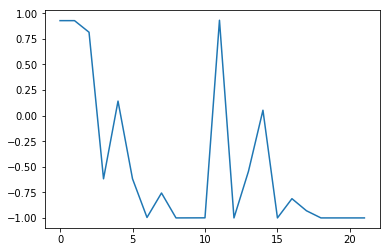

In [21]:
import matplotlib.pyplot as plt
plt.plot(cost_val)
plt.show

２０回くらいのパラメータ更新を経て-1の値に収束していることがわかる。

最小値は、

In [22]:
res.fun

-0.9999999999641714

そのときのパラメータは、

In [23]:
res.x

array(3.92698235)

である。このときの量子状態は、

In [24]:
OneQubitPQC(res.x)

array([-0.38267952+0.j,  0.92388115+0.j])

であり、演算子、H演算の-1の固有状態であることがわかる：

In [25]:
np.dot(H[0],OneQubitPQC(res.x))

array([ 0.38268734+0.j, -0.92387791+0.j])

さて、１量子ビットの簡単な例をみたが、以降では、具体的に２つの問題設定でこの変分量子固有値ソルバーを使ってみよう。

**問題の設定１**（分子のエネルギー計算）：$M$は分子の中にいる電子のエネルギーを表す演算子（ハミルトニアンとよばれる）。このとき$|\psi(x) \rangle$は基底状態（もっともエネルギーが低く安定した分子の状態）、$E$はエネルギーの値。

**問題の設定２**（近似最適化）：$M$はイジング模型と呼ばれる+1と-1の２値をとる変数の関数。この関数は、２値の値をとる変数からなる組合せ最適化問題のコスト関数に対応し、それを最小化する状態$|\psi(x) \rangle$はコストが最小になるような組み合わせパターン（の近似）。



### 分子のエネルギー計算

　実際に、2014年に変分量子固有値ソルバーが提案された論文（Peruzzo et al, Nature Comm 5 4213 (2014)）で実装された水素化ヘリウムイオン（H-He${}^+$）の分子のエネルギーをもとめてみよう。まず、この分子のエネルギーのコスト関数に対応する行列は、２量子ビットを用いて以下のように表される。

In [26]:
define_OneQubitGate(2)
define_TwoQubitGate(2)

In [27]:
M = (-3.8505 * Ide  - 0.2288 * X[1] - 1.0466 * Z[1] - 0.2288 * X[0] +  0.2613 * np.dot(X[0],X[1]) + 0.2288 *np.dot(X[0],Z[1]) - 1.0466*Z[0] + 0.2288* np.dot(Z[0],X[1]) +  0.2356 * np.dot(Z[0],Z[1]) )/2

In [28]:
print(M)

[[-2.85405+0.j  0.     +0.j  0.     +0.j  0.13065+0.j]
 [ 0.     +0.j -2.04305+0.j  0.13065+0.j -0.2288 +0.j]
 [ 0.     +0.j  0.13065+0.j -2.04305+0.j -0.2288 +0.j]
 [ 0.13065+0.j -0.2288 +0.j -0.2288 +0.j -0.76085+0.j]]


さて、２量子ビットのPQCを構成しよう。提案論文のデッドコピーで６つのパラメータが付与された回路構成を行ってみた：

In [29]:
def TwoQubitPQC(phi):
    state = StateZeros(2)
    state = np.dot(RX(0,phi[0]),state)
    state = np.dot(RZ(0,phi[1]),state)
    state = np.dot(RX(1,phi[2]),state)
    state = np.dot(RZ(1,phi[3]),state)
    state = np.dot(CX[1][0],state)
    state = np.dot(RZ(1,phi[4]),state)
    state = np.dot(RX(1,phi[5]),state)
    return state

In [30]:
def cost_func_HHe(phi):
    global cost_val
    tmp = ExpectVal(M,TwoQubitPQC(phi))
    cost_val.append(tmp)
    return tmp

パラメータを入れると分子のエネルギーが得られる関数が定義できた。

In [31]:
cost_func_HHe([np.random.rand() for i in range(6)])

-2.4545709542701424

さっそく最小化してみよう。

-2.8623984082226546


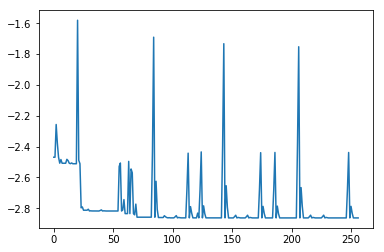

In [32]:
cost_val=[] # コスト関数の履歴
opt = {"maxiter": 100}
res = scipy.optimize.minimize(cost_func_HHe,[np.random.rand() for i in range(6)],options=opt,method='Powell')
plt.plot(cost_val)
plt.show
print(res.fun)

150回程度の繰り返しで、最小値-2.862..を得た。これがどれくらい正しいか答え合わせをするために、Mを厳密に対角化してみよう。対角化は `scipy.linalg`の `eig`で行うことができる。

In [33]:
import scipy.linalg
l, P = scipy.linalg.eig( M )
v = np.transpose(P)
print(l) # 固有値
#print(v) # 固有ベクトル

[-2.86262076+0.j -0.66884541+0.j -1.99583383+0.j -2.1737    +0.j]


固有値は-2.86262076であり、４桁目まで一致している。

実際には、コスト関数の評価は量子コンピュータからの出力を測定し、平均値を求めることによって行う。このため、コスト関数にノイズが実際には入るであろう。`np.random.normal`で正規分布のノイズをふかしてみる。

In [34]:
def cost_func_HHe_noise(phi):
    global cost_val
    tmp = ExpectVal(M,TwoQubitPQC(phi))+np.random.normal(0,0.01)
    cost_val.append(tmp)
    return tmp

-2.8471201122688403


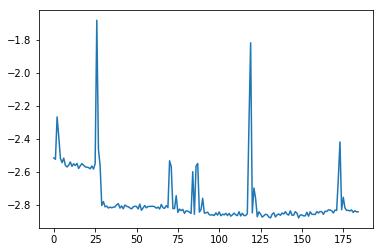

In [35]:
cost_val=[] # コスト関数の履歴
opt = {"maxiter": 100}
res = scipy.optimize.minimize(cost_func_HHe_noise,[np.random.rand() for i in range(6)],options=opt,method='Powell')
plt.plot(cost_val)
plt.show
print(res.fun)

ノイズが多少あっても動くことが確認できた。

### IBM Qの実機を用いた変分量子固有値ソルバー
~~ で解説したIBM Qをpython APIで利用して、変分量子固有値ソルバーを実機を用いて実装してみよう。

In [36]:
from IBMQuantumExperience import IBMQuantumExperience
import IBMQuantumExperience
import Qconfig
api = IBMQuantumExperience.IBMQuantumExperience(Qconfig.APItoken, Qconfig.config)
# Qconfig.pyファイルを編集するか以下の関数に直接トークンを書き込んでください。
# api = IBMQuantumExperience.IBMQuantumExperience("ここにAPItokenを書く",{"url": 'https://quantumexperience.ng.bluemix.net/api'})

Qconfig.pyファイルの中身は、以下のようなものでよい。
```
APItoken ="ここにトークンをいれる"

config = {
  "url": 'https://quantumexperience.ng.bluemix.net/api'
}

if 'APItoken' not in locals():
  raise Exception("Please set up your access token. See Qconfig.py.")

```

QASM形式で雛形となる回路を記述し、パラメータをテキストを置き換えることで代入する。

In [209]:
#PQCをQASMで定義
IBM_PQC_format = """
include "qelib1.inc";

qreg q[5];
creg c[5];

h q[1];
h q[2];
u1(phi1) q[1];
u1(phi3) q[2];
h q[1];
h q[2];
u1(phi2) q[1];
u1(phi4) q[2];
cx q[2],q[1];

u1(phi8) q[1];
h q[1];
u1(phi7) q[1];
h q[1];

h q[qone];
h q[qtwo];

measure q[1] -> c[1];
measure q[2] -> c[2];
"""

def PQC_QASM(phi,q1_meas,q2_meas):
    global IBM_PQC_format
    
    phi1 = phi[0]
    phi2 = phi[1]
    phi3 = phi[2]
    phi4 = phi[3]
    phi7 = phi[4]
    phi8 = phi[5]

    tmpPQC = IBM_PQC_format
    tmpPQC = tmpPQC.replace("phi1","{0:f}".format(phi1))
    tmpPQC = tmpPQC.replace("phi2","{0:f}".format(phi2))
    tmpPQC = tmpPQC.replace("phi3","{0:f}".format(phi3))
    tmpPQC = tmpPQC.replace("phi4","{0:f}".format(phi4))
    tmpPQC = tmpPQC.replace("phi7","{0:f}".format(phi7))
    tmpPQC = tmpPQC.replace("phi8","{0:f}".format(phi8))

    if q1_meas == 1: #測定の基底をスイッチ
        if q2_meas == 1: #測定の基底をスイッチ
            tmpPQC = tmpPQC.replace("h q[qtwo]","h q[2]")
            tmpPQC = tmpPQC.replace("h q[qone]","h q[1]")
        else:
            tmpPQC = tmpPQC.replace("h q[qtwo];","")
            tmpPQC = tmpPQC.replace("h q[qone]","h q[1]")
    else: 
        if q2_meas == 1: #測定の基底をスイッチ
            tmpPQC = tmpPQC.replace("h q[qtwo]","h q[2]")
            tmpPQC = tmpPQC.replace("h q[qone];","")
        else:
            tmpPQC = tmpPQC.replace("h q[qtwo];","")
            tmpPQC = tmpPQC.replace("h q[qone];","")            
            
   # print(IBM_PQC,"cricuit")
    return tmpPQC

In [127]:
PQC_QASM([np.random.rand() for i in range(6)],1,1)

'\ninclude "qelib1.inc";\n\nqreg q[5];\ncreg c[5];\n\nh q[1];\nh q[2];\nu1(0.287439) q[1];\nu1(0.625333) q[2];\nh q[1];\nh q[2];\nu1(0.569541) q[1];\nu1(0.115600) q[2];\ncx q[1],q[2];\n\nu1(0.511232) q[2];\nh q[2];\nu1(0.929891) q[2];\nh q[2];\n\nh q[1];\nh q[2];\n\nmeasure q[1] -> c[1];\nmeasure q[2] -> c[2];\n'

この量子回路構成を実行し、その結果から、Mの期待値を計算してコスト関数を評価する。

In [204]:
def doExperiment(circuitQASM):
    backend = "ibmq_qasm_simulator"
    qcircuit = [{'qasm': 'OPENQASM 2.0;\n'+circuitQASM}]
    response = api.run_job(qcircuit, backend, shots = 8192 , max_credits = 5)
    id = response["id"]
    while(response["status"]=='RUNNING'):
        import time
        time.sleep(0.1)
        response = api.get_job(id)
        print("request...{}, return {}".format(id,response["status"]))
    
    #'RUNNING'が終わると get_jobの値を返す
    return response

In [212]:
def getCounts(s,result):
    if(s not in result["qasms"][0]["data"]["counts"]):
        return 0.
    else:
        return result["qasms"][0]["data"]["counts"][s]

In [213]:
print(PQC_QASM([0.0 for i in range(6)],0,0))


include "qelib1.inc";

qreg q[5];
creg c[5];

h q[1];
h q[2];
u1(0.000000) q[1];
u1(0.000000) q[2];
h q[1];
h q[2];
u1(0.000000) q[1];
u1(0.000000) q[2];
cx q[2],q[1];

u1(0.000000) q[1];
h q[1];
u1(0.000000) q[1];
h q[1];




measure q[1] -> c[1];
measure q[2] -> c[2];



動作確認をしておこう。

In [210]:
#test
phi = [0 for i in range(6)]
hoge = """
include "qelib1.inc";

qreg q[5];
creg c[5];

h q[1];
h q[2];
u1(0.000000) q[1];
u1(0.000000) q[2];
h q[1];
h q[2];
u1(0.000000) q[1];
u1(0.000000) q[2];
cx q[2],q[1];

u1(0.000000) q[1];
h q[1];
u1(0.000000) q[1];
h q[1];


measure q[1] -> c[1];
measure q[2] -> c[2];
"""
#result = doExperiment(hoge)
result = doExperiment(PQC_QASM(phi,0,0))
print(result)

request...5bdb8e00cf6a0400609188ae, return RUNNING
request...5bdb8e00cf6a0400609188ae, return COMPLETED


In [223]:
def cost_func_IBMQ_Bell(phi):

    result = doExperiment(PQC_QASM(phi,1,1))
    # Hを作用させてから0,1測定し、Xの期待値を計算する。
    val_XI = 2.0*(getCounts("00000",result)+getCounts("00100",result))/8192.0-1.0
    val_IX = 2.0*(getCounts("00000",result)+getCounts("00010",result))/8192.0-1.0
    val_XX = 2.0*(getCounts("00000",result)+getCounts("00110",result))/8192.0-1.0
#    print(result)
#    print(val_XX)

    result = doExperiment(PQC_QASM(phi,0,0))
    # Hを作用させずに0,1測定し、Zの期待値を計算する。
    val_ZI = 2.0*(getCounts("00000",result)+getCounts("00100",result))/8192.0-1.0
    val_IZ = 2.0*(getCounts("00000",result)+getCounts("00010",result))/8192.0-1.0
    val_ZZ = 2.0*(getCounts("00000",result)+getCounts("00110",result))/8192.0-1.0
#    print(result)
#    print(val_ZZ)
    cost = -1.0*(val_ZZ+val_XX)
    print(cost)
    return cost

request...5bdb8f99c27597005dc2e569, return RUNNING
request...5bdb8f99c27597005dc2e569, return COMPLETED
request...5bdb8f9d8d07c6005d5b4503, return RUNNING
request...5bdb8f9d8d07c6005d5b4503, return COMPLETED
-1.456787109375
request...5bdb8fa38d07c6005d5b4505, return RUNNING
request...5bdb8fa38d07c6005d5b4505, return COMPLETED
request...5bdb8fa8c27597005dc2e56b, return RUNNING
request...5bdb8fa8c27597005dc2e56b, return COMPLETED
-1.4609375
request...5bdb8fae4c57c900659fe92f, return RUNNING
request...5bdb8fae4c57c900659fe92f, return COMPLETED
request...5bdb8fb240f85b0050ceb2b6, return RUNNING
request...5bdb8fb240f85b0050ceb2b6, return COMPLETED
-0.63330078125
request...5bdb8fb64c57c900659fe931, return RUNNING
request...5bdb8fb64c57c900659fe931, return COMPLETED
request...5bdb8fbbd806e700512990a1, return RUNNING
request...5bdb8fbbd806e700512990a1, return COMPLETED
-0.470703125
request...5bdb8fc0790fcc0066159316, return RUNNING
request...5bdb8fc0790fcc0066159316, return COMPLETED
request..

request...5bdb9108c28caa005762ae0a, return RUNNING
request...5bdb9108c28caa005762ae0a, return COMPLETED
-1.725830078125
request...5bdb910fc28caa005762ae0c, return RUNNING
request...5bdb910fc28caa005762ae0c, return COMPLETED
request...5bdb91184c57c900659fe942, return RUNNING
request...5bdb91184c57c900659fe942, return COMPLETED
-1.75634765625
request...5bdb911d1f5b740060d08728, return RUNNING
request...5bdb911d1f5b740060d08728, return COMPLETED
request...5bdb91249868670054d3f1a1, return RUNNING
request...5bdb91249868670054d3f1a1, return COMPLETED
-1.785888671875
request...5bdb91289868670054d3f1a3, return RUNNING
request...5bdb91289868670054d3f1a3, return COMPLETED
request...5bdb912c1bf7450056cd17e3, return RUNNING
request...5bdb912c1bf7450056cd17e3, return COMPLETED
-1.7705078125
request...5bdb91319868670054d3f1a5, return RUNNING
request...5bdb91319868670054d3f1a5, return COMPLETED
request...5bdb9135f9ace7005595b019, return RUNNING
request...5bdb9135f9ace7005595b019, return COMPLETED
-1.

request...5bdb9283d806e700512990b9, return COMPLETED
-1.91748046875
request...5bdb9288cf6a0400609188f4, return RUNNING
request...5bdb9288cf6a0400609188f4, return COMPLETED
request...5bdb928cc27597005dc2e589, return RUNNING
request...5bdb928cc27597005dc2e589, return COMPLETED
-1.986572265625
request...5bdb9290c27597005dc2e58b, return RUNNING
request...5bdb9290c27597005dc2e58b, return COMPLETED
request...5bdb9296f9ace7005595b025, return RUNNING
request...5bdb9296f9ace7005595b025, return COMPLETED
-1.9853515625
request...5bdb929bf012da005faa661b, return RUNNING
request...5bdb929bf012da005faa661b, return COMPLETED
request...5bdb929f40f85b0050ceb2c9, return RUNNING
request...5bdb929f40f85b0050ceb2c9, return COMPLETED
-1.987548828125
request...5bdb92a39868670054d3f1ce, return RUNNING
request...5bdb92a39868670054d3f1ce, return COMPLETED
request...5bdb92a81bec39005480d829, return RUNNING
request...5bdb92a81bec39005480d829, return COMPLETED
-1.984130859375
request...5bdb92ae1bf7450056cd17f6, re

request...5bdb942584c92c006256a495, return COMPLETED
request...5bdb94299868670054d3f1e9, return RUNNING
request...5bdb94299868670054d3f1e9, return COMPLETED
-1.984130859375
request...5bdb942d40f85b0050ceb2dd, return RUNNING
request...5bdb942d40f85b0050ceb2dd, return COMPLETED
request...5bdb9431f012da005faa662d, return RUNNING
request...5bdb9431f012da005faa662d, return COMPLETED
-1.986328125
request...5bdb9435790fcc0066159347, return RUNNING
request...5bdb9435790fcc0066159347, return COMPLETED
request...5bdb94391f5b740060d0874b, return RUNNING
request...5bdb94391f5b740060d0874b, return COMPLETED
-1.984130859375
request...5bdb943e9868670054d3f1eb, return RUNNING
request...5bdb943e9868670054d3f1eb, return COMPLETED
request...5bdb94424c57c900659fe980, return RUNNING
request...5bdb94424c57c900659fe980, return COMPLETED
-1.983154296875
request...5bdb944a9e541700548dcd20, return RUNNING
request...5bdb944a9e541700548dcd20, return COMPLETED
request...5bdb944e790fcc006615934a, return RUNNING
req

request...5bdb957b98844100797aa4ed, return RUNNING
request...5bdb957b98844100797aa4ed, return COMPLETED
request...5bdb9580e05ffe0066684922, return RUNNING
request...5bdb9580e05ffe0066684922, return COMPLETED
-1.998779296875
request...5bdb95841bec39005480d841, return RUNNING
request...5bdb95841bec39005480d841, return COMPLETED
request...5bdb9588790fcc006615935e, return RUNNING
request...5bdb9588790fcc006615935e, return COMPLETED
-1.9990234375
request...5bdb958cf9ace7005595b041, return RUNNING
request...5bdb958cf9ace7005595b041, return COMPLETED
request...5bdb9590d806e700512990f8, return RUNNING
request...5bdb9590d806e700512990f8, return COMPLETED
-1.998779296875
request...5bdb95998d07c6005d5b453d, return RUNNING
request...5bdb95998d07c6005d5b453d, return COMPLETED
request...5bdb959e245e40005c3ac09a, return RUNNING
request...5bdb959e245e40005c3ac09a, return COMPLETED
-2.0
request...5bdb95a21bf7450056cd1810, return RUNNING
request...5bdb95a21bf7450056cd1810, return COMPLETED
request...5bd

request...5bdb96ea9868670054d3f214, return RUNNING
request...5bdb96ea9868670054d3f214, return COMPLETED
-1.999267578125
request...5bdb96ee9868670054d3f216, return RUNNING
request...5bdb96ee9868670054d3f216, return COMPLETED
request...5bdb96f2f012da005faa665d, return RUNNING
request...5bdb96f2f012da005faa665d, return COMPLETED
-1.793212890625
request...5bdb96f7245e40005c3ac0b2, return RUNNING
request...5bdb96f7245e40005c3ac0b2, return COMPLETED
request...5bdb96fe4c57c900659fe9a9, return RUNNING
request...5bdb96fe4c57c900659fe9a9, return COMPLETED
-1.897705078125
request...5bdb97031bf7450056cd1828, return RUNNING
request...5bdb97031bf7450056cd1828, return COMPLETED
request...5bdb9708790fcc0066159373, return RUNNING
request...5bdb9708790fcc0066159373, return COMPLETED
-2.0
request...5bdb970c9e541700548dcd45, return RUNNING
request...5bdb970c9e541700548dcd45, return COMPLETED
request...5bdb9710f9ace7005595b099, return RUNNING
request...5bdb9710f9ace7005595b099, return COMPLETED
-2.0
reques

request...5bdb98631bec39005480d872, return COMPLETED
request...5bdb98679868670054d3f22a, return RUNNING
request...5bdb98679868670054d3f22a, return COMPLETED
-1.999755859375
request...5bdb986bf012da005faa666b, return RUNNING
request...5bdb986bf012da005faa666b, return COMPLETED
request...5bdb986f801f3d0058939c56, return RUNNING
request...5bdb986f801f3d0058939c56, return COMPLETED
-1.999755859375
request...5bdb9873d806e70051299122, return RUNNING
request...5bdb9873d806e70051299122, return COMPLETED
request...5bdb9879e05ffe006668494a, return RUNNING
request...5bdb9879e05ffe006668494a, return COMPLETED
-2.0
request...5bdb987dc28caa005762ae5a, return RUNNING
request...5bdb987dc28caa005762ae5a, return RUNNING
request...5bdb987dc28caa005762ae5a, return COMPLETED
request...5bdb98839868670054d3f22c, return RUNNING
request...5bdb98839868670054d3f22c, return COMPLETED
-2.0
request...5bdb988784c92c006256a4fc, return RUNNING
request...5bdb988784c92c006256a4fc, return COMPLETED
request...5bdb988c40f8

request...5bdb99c6e05ffe006668495d, return RUNNING
request...5bdb99c6e05ffe006668495d, return COMPLETED
-1.999755859375
request...5bdb99cb9868670054d3f235, return RUNNING
request...5bdb99cb9868670054d3f235, return COMPLETED
request...5bdb99cf245e40005c3ac0d2, return RUNNING
request...5bdb99cf245e40005c3ac0d2, return COMPLETED
-1.552001953125
request...5bdb99d6790fcc0066159389, return COMPLETED
request...5bdb99dec28caa005762ae67, return RUNNING
request...5bdb99dec28caa005762ae67, return COMPLETED
-0.955322265625
request...5bdb99e41bec39005480d880, return RUNNING
request...5bdb99e41bec39005480d880, return COMPLETED
request...5bdb99e8c27597005dc2e5db, return RUNNING
request...5bdb99e8c27597005dc2e5db, return COMPLETED
-1.99951171875
request...5bdb99eec28caa005762ae69, return RUNNING
request...5bdb99eec28caa005762ae69, return RUNNING
request...5bdb99eec28caa005762ae69, return COMPLETED
request...5bdb99f4cf6a04006091899d, return RUNNING
request...5bdb99f4cf6a04006091899d, return COMPLETED
-

request...5bdb9b3bd806e70051299136, return COMPLETED
request...5bdb9b3fc28caa005762ae80, return RUNNING
request...5bdb9b3fc28caa005762ae80, return COMPLETED
-1.998291015625
request...5bdb9b4340f85b0050ceb329, return RUNNING
request...5bdb9b4340f85b0050ceb329, return COMPLETED
request...5bdb9b49cf6a0400609189a8, return RUNNING
request...5bdb9b49cf6a0400609189a8, return COMPLETED
-1.9990234375
request...5bdb9b4dc27597005dc2e5e7, return RUNNING
request...5bdb9b4dc27597005dc2e5e7, return COMPLETED
request...5bdb9b51d806e70051299138, return RUNNING
request...5bdb9b51d806e70051299138, return COMPLETED
-1.999267578125
request...5bdb9b56801f3d0058939c73, return RUNNING
request...5bdb9b56801f3d0058939c73, return COMPLETED
request...5bdb9b5c790fcc0066159395, return RUNNING
request...5bdb9b5c790fcc0066159395, return COMPLETED
-2.0
request...5bdb9b60c27597005dc2e5ea, return RUNNING
request...5bdb9b60c27597005dc2e5ea, return COMPLETED
request...5bdb9b641bec39005480d88d, return RUNNING
request...5bd

request...5bdb9c9cc27597005dc2e5fc, return RUNNING
request...5bdb9c9cc27597005dc2e5fc, return COMPLETED
-1.81787109375
request...5bdb9ca0d806e7005129914b, return RUNNING
request...5bdb9ca0d806e7005129914b, return COMPLETED
request...5bdb9ca5f012da005faa669f, return RUNNING
request...5bdb9ca5f012da005faa669f, return COMPLETED
-1.927734375
request...5bdb9ca91bf7450056cd1864, return RUNNING
request...5bdb9ca91bf7450056cd1864, return COMPLETED
request...5bdb9cadf9ace7005595b1bf, return RUNNING
request...5bdb9cadf9ace7005595b1bf, return COMPLETED
-1.99951171875
request...5bdb9cb2e05ffe006668497a, return RUNNING
request...5bdb9cb2e05ffe006668497a, return COMPLETED
request...5bdb9cb7245e40005c3ac0f7, return RUNNING
request...5bdb9cb7245e40005c3ac0f7, return COMPLETED
-1.974365234375
request...5bdb9cbce05ffe006668497c, return RUNNING
request...5bdb9cbce05ffe006668497c, return COMPLETED
request...5bdb9cc1c27597005dc2e5fe, return RUNNING
request...5bdb9cc1c27597005dc2e5fe, return COMPLETED
-1.99

request...5bdb9e12790fcc00661593ac, return RUNNING
request...5bdb9e12790fcc00661593ac, return COMPLETED
request...5bdb9e188d07c6005d5b4596, return RUNNING
request...5bdb9e188d07c6005d5b4596, return COMPLETED
-1.998291015625
request...5bdb9e1c9e541700548dcd8b, return RUNNING
request...5bdb9e1c9e541700548dcd8b, return COMPLETED
request...5bdb9e21d806e70051299158, return RUNNING
request...5bdb9e21d806e70051299158, return COMPLETED
-2.0
request...5bdb9e2540f85b0050ceb349, return RUNNING
request...5bdb9e2540f85b0050ceb349, return COMPLETED
request...5bdb9e2a9e541700548dcd8d, return RUNNING
request...5bdb9e2a9e541700548dcd8d, return COMPLETED
-1.9990234375
request...5bdb9e2ef012da005faa66ad, return RUNNING
request...5bdb9e2ef012da005faa66ad, return COMPLETED
request...5bdb9e32cf6a0400609189de, return RUNNING
request...5bdb9e32cf6a0400609189de, return COMPLETED
-1.99951171875
request...5bdb9e37e05ffe0066684986, return RUNNING
request...5bdb9e37e05ffe0066684986, return COMPLETED
request...5bdb

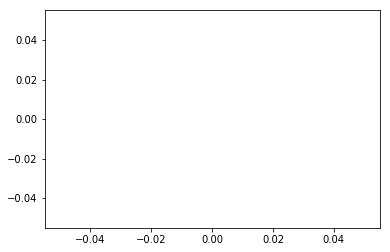

In [224]:
cost_val=[] # コスト関数の履歴
opt = {"maxiter": 10}
res = scipy.optimize.minimize(cost_func_IBMQ_Bell,[np.random.rand() for i in range(6)],options=opt,method='Powell')
plt.plot(cost_val)
plt.show
print(res.fun)

In [227]:
print(res.fun)

-2.0


$M=-X\otimes X-Z \otimes Z$の最小固有状態は、$|00\rangle + |11\rangle /\sqrt(2)$であり固有値は$-2$となることから正しい答えが得られている。

In [232]:
def cost_func_IBMQ_HHe(phi):

    result = doExperiment(PQC_QASM(phi,1,1))
    # Hを作用させてから0,1測定し、Xの期待値を計算する。
    val_XI = 2.0*(getCounts("00000",result)+getCounts("00100",result))/8192.0-1.0
    val_IX = 2.0*(getCounts("00000",result)+getCounts("00010",result))/8192.0-1.0
    val_XX = 2.0*(getCounts("00000",result)+getCounts("00110",result))/8192.0-1.0
    #print(val_XX)

    result = doExperiment(PQC_QASM(phi,0,0))
    # Hを作用させずに0,1測定し、Zの期待値を計算する。
    val_ZI = 2.0*(getCounts("00000",result)+getCounts("00100",result))/8192.0-1.0
    val_IZ = 2.0*(getCounts("00000",result)+getCounts("00010",result))/8192.0-1.0
    val_ZZ = 2.0*(getCounts("00000",result)+getCounts("00110",result))/8192.0-1.0
    #print(val_ZZ)

    result = doExperiment(PQC_QASM(phi,1,0))
    # 片方だけHを作用させ0,1測定し、XZの期待値を計算する。
    val_XZ = 2.0*(getCounts("00000",result)+getCounts("00110",result))/8192.0-1.0

    result = doExperiment(PQC_QASM(phi,0,1))
    # 片方だけHを作用させ0,1測定し、zxの期待値を計算する。
    val_ZX = 2.0*(getCounts("00000",result)+getCounts("00110",result))/8192.0-1.0

    energy = (-3.8505-0.2288*val_IX-1.0466*val_IZ-0.2288*val_XI+0.2613*val_XX+0.2288*val_XZ-1.0466*val_ZI+0.2288*val_ZX+0.2356*val_ZZ)/2

    print(energy)
    return energy

In [233]:
cost_val=[] # コスト関数の履歴
opt = {"maxiter": 100}
res = scipy.optimize.minimize(cost_func_IBMQ_HHe,[np.random.rand() for i in range(6)],options=opt,method='Powell')
plt.plot(cost_val)
plt.show
print(res.fun)

request...5bdbb028801f3d0058939cbb, return RUNNING
request...5bdbb028801f3d0058939cbb, return COMPLETED
request...5bdbb02c98844100797aa566, return RUNNING
request...5bdbb02c98844100797aa566, return COMPLETED
request...5bdbb032801f3d0058939cbd, return RUNNING
request...5bdbb032801f3d0058939cbd, return COMPLETED
request...5bdbb036d806e7005129917e, return RUNNING
request...5bdbb036d806e7005129917e, return COMPLETED
-2.7190333984374995
request...5bdbb03a801f3d0058939cbf, return RUNNING
request...5bdbb03a801f3d0058939cbf, return COMPLETED
request...5bdbb03ee05ffe0066684aaf, return RUNNING
request...5bdbb03ee05ffe0066684aaf, return COMPLETED
request...5bdbb04584c92c006256a55f, return COMPLETED
request...5bdbb0504c57c900659fea18, return RUNNING
request...5bdbb0504c57c900659fea18, return COMPLETED
-2.7209767089843746
request...5bdbb054c27597005dc2e644, return RUNNING
request...5bdbb054c27597005dc2e644, return COMPLETED
request...5bdbb05b9e541700548dcdc1, return RUNNING
request...5bdbb05b9e5417

request...5bdbb19cf9ace7005595b206, return COMPLETED
request...5bdbb1a11f5b740060d087f9, return RUNNING
request...5bdbb1a11f5b740060d087f9, return COMPLETED
-2.8157562255859374
request...5bdbb1a5790fcc00661593f2, return RUNNING
request...5bdbb1a5790fcc00661593f2, return COMPLETED
request...5bdbb1a9c27597005dc2e64b, return RUNNING
request...5bdbb1a9c27597005dc2e64b, return COMPLETED
request...5bdbb1ad1bf7450056cd18b6, return RUNNING
request...5bdbb1ad1bf7450056cd18b6, return COMPLETED
request...5bdbb1b24c57c900659fea22, return RUNNING
request...5bdbb1b24c57c900659fea22, return COMPLETED
-2.802448754882812
request...5bdbb1b69e541700548dcdcb, return RUNNING
request...5bdbb1b69e541700548dcdcb, return COMPLETED
request...5bdbb1bac27597005dc2e64d, return RUNNING
request...5bdbb1bac27597005dc2e64d, return COMPLETED
request...5bdbb1bf4c57c900659fea24, return RUNNING
request...5bdbb1bf4c57c900659fea24, return COMPLETED
request...5bdbb1c41f5b740060d087fb, return RUNNING
request...5bdbb1c41f5b740

request...5bdbb304c27597005dc2e65f, return RUNNING
request...5bdbb304c27597005dc2e65f, return COMPLETED
request...5bdbb30884c92c006256a574, return RUNNING
request...5bdbb30884c92c006256a574, return COMPLETED
-2.8123763671875
request...5bdbb30dd806e7005129919c, return RUNNING
request...5bdbb30dd806e7005129919c, return COMPLETED
request...5bdbb3119868670054d3f2a8, return RUNNING
request...5bdbb3119868670054d3f2a8, return COMPLETED
request...5bdbb317245e40005c3ac14d, return RUNNING
request...5bdbb317245e40005c3ac14d, return COMPLETED
request...5bdbb31c4c57c900659fea36, return RUNNING
request...5bdbb31c4c57c900659fea36, return COMPLETED
-2.8122596923828125
request...5bdbb3209868670054d3f2b1, return RUNNING
request...5bdbb3209868670054d3f2b1, return COMPLETED
request...5bdbb325801f3d0058939ce8, return RUNNING
request...5bdbb325801f3d0058939ce8, return COMPLETED
request...5bdbb32a9868670054d3f2b6, return RUNNING
request...5bdbb32a9868670054d3f2b6, return COMPLETED
request...5bdbb32fd806e7005

request...5bdbb48ec28caa005762aefc, return COMPLETED
request...5bdbb4959e541700548dcdf3, return RUNNING
request...5bdbb4959e541700548dcdf3, return COMPLETED
request...5bdbb499245e40005c3ac16f, return RUNNING
request...5bdbb499245e40005c3ac16f, return COMPLETED
request...5bdbb49f790fcc0066159421, return RUNNING
request...5bdbb49f790fcc0066159421, return COMPLETED
-2.810145922851563
request...5bdbb4a31bec39005480d90e, return RUNNING
request...5bdbb4a31bec39005480d90e, return COMPLETED
request...5bdbb4a81bf7450056cd18da, return RUNNING
request...5bdbb4a81bf7450056cd18da, return COMPLETED
request...5bdbb4ac801f3d0058939d03, return RUNNING
request...5bdbb4ac801f3d0058939d03, return COMPLETED
request...5bdbb4b0f9ace7005595b230, return RUNNING
request...5bdbb4b0f9ace7005595b230, return COMPLETED
-2.4984919189453123
request...5bdbb4b5d806e700512991b3, return RUNNING
request...5bdbb4b5d806e700512991b3, return COMPLETED
request...5bdbb4b9f9ace7005595b232, return RUNNING
request...5bdbb4b9f9ace70

request...5bdbb6179868670054d3f2d6, return RUNNING
request...5bdbb6179868670054d3f2d6, return COMPLETED
request...5bdbb61bc27597005dc2e68b, return RUNNING
request...5bdbb61bc27597005dc2e68b, return COMPLETED
request...5bdbb620f012da005faa671f, return RUNNING
request...5bdbb620f012da005faa671f, return COMPLETED
request...5bdbb6258d07c6005d5b460f, return RUNNING
request...5bdbb6258d07c6005d5b460f, return COMPLETED
-2.8578086547851553
request...5bdbb6291f5b740060d0883a, return RUNNING
request...5bdbb6291f5b740060d0883a, return COMPLETED
request...5bdbb62d245e40005c3ac182, return RUNNING
request...5bdbb62d245e40005c3ac182, return COMPLETED
request...5bdbb631245e40005c3ac185, return RUNNING
request...5bdbb631245e40005c3ac185, return COMPLETED
request...5bdbb6351bf7450056cd18eb, return RUNNING
request...5bdbb6351bf7450056cd18eb, return COMPLETED
-2.856728173828125
request...5bdbb63a801f3d0058939d1a, return RUNNING
request...5bdbb63a801f3d0058939d1a, return COMPLETED
request...5bdbb63e8d07c60

request...5bdbb786e05ffe0066684c0b, return RUNNING
request...5bdbb786e05ffe0066684c0b, return COMPLETED
-2.8543497924804684
request...5bdbb78ac28caa005762af2a, return RUNNING
request...5bdbb78ac28caa005762af2a, return COMPLETED
request...5bdbb78f8d07c6005d5b461e, return RUNNING
request...5bdbb78f8d07c6005d5b461e, return COMPLETED
request...5bdbb793245e40005c3ac191, return RUNNING
request...5bdbb793245e40005c3ac191, return COMPLETED
request...5bdbb7979868670054d3f2e1, return RUNNING
request...5bdbb7979868670054d3f2e1, return COMPLETED
-2.855131298828124
request...5bdbb79cd806e700512991da, return RUNNING
request...5bdbb79cd806e700512991da, return COMPLETED
request...5bdbb7a0d806e700512991dc, return RUNNING
request...5bdbb7a0d806e700512991dc, return COMPLETED
request...5bdbb7a41f5b740060d08849, return RUNNING
request...5bdbb7a41f5b740060d08849, return COMPLETED
request...5bdbb7a98d07c6005d5b4620, return RUNNING
request...5bdbb7a98d07c6005d5b4620, return COMPLETED
-2.854311791992187
reques

request...5bdbb9081bec39005480d941, return COMPLETED
-2.8573428466796877
request...5bdbb90cd806e700512991f6, return RUNNING
request...5bdbb90cd806e700512991f6, return COMPLETED
request...5bdbb9101f5b740060d0886f, return RUNNING
request...5bdbb9101f5b740060d0886f, return COMPLETED
request...5bdbb91740f85b0050ceb3f2, return RUNNING
request...5bdbb91740f85b0050ceb3f2, return COMPLETED
request...5bdbb91de05ffe0066684c29, return RUNNING
request...5bdbb91de05ffe0066684c29, return COMPLETED
-2.8546170654296876
request...5bdbb924e05ffe0066684c2b, return RUNNING
request...5bdbb924e05ffe0066684c2b, return COMPLETED
request...5bdbb928cf6a040060918adc, return RUNNING
request...5bdbb928cf6a040060918adc, return COMPLETED
request...5bdbb92c8d07c6005d5b4642, return RUNNING
request...5bdbb92c8d07c6005d5b4642, return COMPLETED
request...5bdbb93b98844100797aa5b8, return RUNNING
request...5bdbb93b98844100797aa5b8, return COMPLETED
-2.8567518676757815
request...5bdbb93fd806e700512991f9, return RUNNING
requ

request...5bdbba9fc28caa005762af4b, return COMPLETED
request...5bdbbaa41bec39005480d953, return RUNNING
request...5bdbbaa41bec39005480d953, return COMPLETED
-2.8597851928710942
request...5bdbbaa884c92c006256a5ee, return RUNNING
request...5bdbbaa884c92c006256a5ee, return COMPLETED
request...5bdbbaad4c57c900659fea83, return RUNNING
request...5bdbbaad4c57c900659fea83, return COMPLETED
request...5bdbbab19e541700548dce48, return RUNNING
request...5bdbbab19e541700548dce48, return COMPLETED
request...5bdbbab51bf7450056cd1926, return RUNNING
request...5bdbbab51bf7450056cd1926, return COMPLETED
-2.8637420288085935
request...5bdbbaba9868670054d3f315, return RUNNING
request...5bdbbaba9868670054d3f315, return COMPLETED
request...5bdbbabf1bec39005480d955, return RUNNING
request...5bdbbabf1bec39005480d955, return COMPLETED
request...5bdbbac798844100797aa5c5, return RUNNING
request...5bdbbac798844100797aa5c5, return COMPLETED
request...5bdbbacc245e40005c3ac1b2, return RUNNING
request...5bdbbacc245e40

ConnectionError: HTTPSConnectionPool(host='quantumexperience.ng.bluemix.net', port=443): Max retries exceeded with url: /api/Jobs/5bdbbaeae05ffe0066684c38?access_token=8OhGGRUebxaewjNGalclagxJEGUagW1q07XzrXFHiMVanAf25WWS7P1A44gx2TBB (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x10954deb8>: Failed to establish a new connection: [Errno 60] Operation timed out',))

-2.862 の値が得られ、NumPyで計算したものとほぼ同じ結果が得られた。`"ibmq_qasm_simulator"`を実機に変えれば実機で実行することができるので、試してもらいたい。（実機の場合は、計算結果を得られるまでに待ち時間があるため、相当時間がかかると思います）

## 近似量子最適化（QAOA）
次に、近似量子最適化について説明しよう。近似量子最適化（QAOA: quantum approximated optimization algorithm）は、横磁場イジングモデルという磁性体のモデルを用いた組み合わせ最適化のためのヒューリスティック法である量子アニーリングを拡張したものである。量子アニーリングでは、断熱的な操作をすることによって、コスト関数が小さくなるようなパターンを近似解として求めるが、QAOAでは、パラメータ付き量子回路を用いることによって、かならずしも断熱的ではない時間発展からパラメータを調整してコスト関数が小さくなるようなパラメータを見つける。$\langle \psi | M | \psi \rangle$は、量子ビット数に対応する$n$ビットのビット列を入力とした組み合わせ最適化のためのコスト関数である。

具体的には、+1,-1の２つの値をとる変数$\{ s_i \}$の２次関数、
$$
f(s) = \sum _{i,j} J[i][j] s_i *s_j + h_i * s_i
$$
とする（このような２値変数の２次式で与えられるようなコスト関数はイジング型のコスト関数と呼ばれ、様々な問題をここの形式に変換することができる）。$J[i][j]$と$h_i$は与えられた最適化問題から決まる係数である。このとき、$s_i$を$i$番目の量子ビットにさようする$Z$演算子（行列）、Z[i]に対応させることによって、コスト関数を与える行列$M$を定義することができる。

In [235]:
nqubits=4
define_OneQubitGate(nqubits)

J = [[0 for i in range(nqubits)] for j in range(nqubits)]
h = [0 for j in range(nqubits)]

def define_cost_Matrix_Ising(nqubits):
    # ランダムに問題を設定してみる
    global J,h

    J = [[(2*np.random.rand()-1.0) for i in range(nqubits)] for j in range(nqubits)]
    h = [(2*np.random.rand()-1.0) for i in range(nqubits)] 
    M = np.zeros((2**nqubits,2**nqubits))
    
    for i in range(nqubits):
        for j in range(nqubits):
            if(j < i):
                M = M+ J[i][j]* np.dot(Z[i],Z[j]) 
        M = M+ h[i]* Z[i]
    return M

パラメタ付き量子回路の構成には、$M$そのものを利用してみよう。

In [237]:
def define_PQC_QAOA(phi,nqubits,depth,M):
    state = StateZeros(nqubits)
    #最初にすべてのビット列の重ね合わせをつくる。
#    for i in range(nqubits):
#        state = np.dot(H[i],state)
        
    for j in range(depth):
        for i in range(nqubits):
            #重ね合せの重みをかえる
            state = np.dot(RX(i,phi[2*j]),state)

        #コスト関数に依存して複素重みを調整する
        state = np.dot(expm(-1.0j*M*phi[2*j+1]),state)
    return state

以前の場合と同様に、コストを評価する関数を作る

In [320]:
cost_val = []

def cost_Ising(phi):
    tmp = ExpectVal(M,define_PQC_QAOA(phi,nqubits,depth,M))
    cost_val.append(tmp)
    tmp = tmp 
    return tmp

In [250]:
nqubits = 4
depth = 4
define_OneQubitGate(nqubits)
M = define_cost_Matrix_Ising(nqubits)
cost_Ising([np.random.rand() for i in range(2*depth)])

-0.6377296819581939

-1.928522491728081


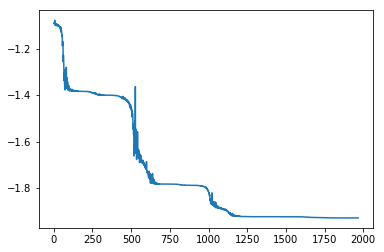

In [251]:
cost_val=[] # コスト関数の履歴
opt = {"maxiter": 5000}
res = scipy.optimize.minimize(cost_Ising,[np.random.rand() for i in range(2*depth)],options=opt,method='Nelder-Mead')
plt.plot(cost_val)
plt.show
print(res.fun)

この状態を測定したときに、もっとも出現確率が高いビット列は、

In [331]:
def get_high_prob_bitstring(state):
    high_prob_bits = 0
    highest_prob = 0
    
    for i in range(2**nqubits):
        tmp_prob = abs(state[i])**2
        
        if tmp_prob > highest_prob:         
            highest_prob = tmp_prob
            high_prob_bits = i
    print(high_prob_bits)

を用いて、

In [332]:
state = define_PQC_QAOA(res.x,nqubits,depth,M)
get_high_prob_bitstring(state)

10


と得られる。すべてのパターンに対するコストを列挙してみて、これがどの程度最適解に近いかみておこう。

In [333]:
def get_cost_list():
    cost_list = []
    for i in range(2**nqubits):
        state = np.zeros(2**nqubits)
        state[i] = 1
        print(i,ExpectVal(M,state))
        cost_list.append(ExpectVal(M,state))
    return cost_list

In [334]:
get_cost_list()

0 1.2006863921656559
1 0.9633022184105244
2 -3.001057338206019
3 0.32497542355858444
4 0.38639278708214686
5 -2.120680113941437
6 -0.9613103294190273
7 0.09503370507712416
8 2.3521524566013907
9 -0.12730189705672634
10 -3.1476083012724168
11 -2.063645719410799
12 1.013340059016086
13 -3.735803021910484
14 -1.6323800849872212
15 -2.8181062303940556
16 0.08760735405906428
17 -1.0071037065850459
18 -3.22225235073115
19 -0.7535464758555261
20 2.4154282260852495
21 -0.9489715618273127
22 1.9596091351655351
23 2.158626282772708
24 3.606562377577476
25 0.26978113703037954
26 -1.0013143547148726
27 -0.7746786597422333
28 5.409864457101865
29 -0.19660551071368326
30 3.6560283386800174
31 1.6129753063842043


[1.2006863921656559,
 0.9633022184105244,
 -3.001057338206019,
 0.32497542355858444,
 0.38639278708214686,
 -2.120680113941437,
 -0.9613103294190273,
 0.09503370507712416,
 2.3521524566013907,
 -0.12730189705672634,
 -3.1476083012724168,
 -2.063645719410799,
 1.013340059016086,
 -3.735803021910484,
 -1.6323800849872212,
 -2.8181062303940556,
 0.08760735405906428,
 -1.0071037065850459,
 -3.22225235073115,
 -0.7535464758555261,
 2.4154282260852495,
 -0.9489715618273127,
 1.9596091351655351,
 2.158626282772708,
 3.606562377577476,
 0.26978113703037954,
 -1.0013143547148726,
 -0.7746786597422333,
 5.409864457101865,
 -0.19660551071368326,
 3.6560283386800174,
 1.6129753063842043]

今回は、最小となるパターンが得られていることが確認できる。

In [329]:
nqubits = 5
depth = 6
define_OneQubitGate(nqubits)
M = define_cost_Matrix_Ising(nqubits)

cost_val=[] # コスト関数の履歴
opt = {"maxiter": 1000}
res = scipy.optimize.minimize(cost_Ising,[np.random.rand() for i in range(2*depth)],options=opt,method='Powell')

#print(res.fun)
state = define_PQC_QAOA(res.x,nqubits,depth,M)
#print(state)
get_high_prob_bitstring(state)
cost_list = get_cost_list()

10
0 1.2006863921656559
1 0.9633022184105244
2 -3.001057338206019
3 0.32497542355858444
4 0.38639278708214686
5 -2.120680113941437
6 -0.9613103294190273
7 0.09503370507712416
8 2.3521524566013907
9 -0.12730189705672634
10 -3.1476083012724168
11 -2.063645719410799
12 1.013340059016086
13 -3.735803021910484
14 -1.6323800849872212
15 -2.8181062303940556
16 0.08760735405906428
17 -1.0071037065850459
18 -3.22225235073115
19 -0.7535464758555261
20 2.4154282260852495
21 -0.9489715618273127
22 1.9596091351655351
23 2.158626282772708
24 3.606562377577476
25 0.26978113703037954
26 -1.0013143547148726
27 -0.7746786597422333
28 5.409864457101865
29 -0.19660551071368326
30 3.6560283386800174
31 1.6129753063842043


系が大きくしていくと最適解とまではいかないが、コスト関数が低いパターンがえられている。

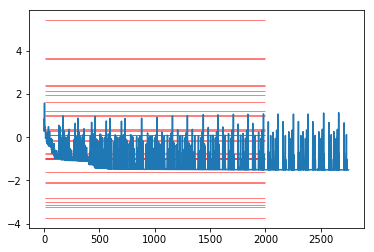

In [330]:
fig, graph = plt.subplots()
graph.plot(cost_val)
for i in range(2**nqubits):
    graph.hlines(y=cost_list[i], xmin=4, xmax=2000, linewidth=0.5, color='r')
plt.show()

In [ ]:
水平な線が、それぞれのパターンのコスト関数である。

### まとめ
ここでは、NumPyをもちいて、量子計算を数値的にシミュレーションし、量子古典ハイブリッドアルゴリズムを実装してみました。位相推定アルゴリズムとは異なり、量子古典ハイブリッドアルゴリズムでは、パラメータを導入した量子回路のパラメータの最適化を古典コンピュータをもちいて実行する、ハイブリッドなアプローチで、分子のエネルギー計算や、最適化問題の近似解を得ようというものである。この方法の利点は、量子回路部分の負担を減らすことができるので、現在実現している規模で、かつ、ある程度ノイズを含むようなデバイスでも動作するという点である。一方で、この方法は、量子コンピュータをもちいてヒューリスティック法なので、従来コンピュータに対する優位性は保証されていないことにも注意しておくべきだ。とはいえ、従来コンピュータでもヒューリスティック法はさまざまな局面で利用されている。量子コンピュータを利用することによって、大きなアドバンテージが生まれるような問題を見つけることが期待されている。